In [1]:
import sys
sys.path.append('../code')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
import read_video as rv
import reconstruction_utils as ru

In [ ]:
import Reconstruction_pytorch as rec

In [4]:
filepath = 'D:/mCherryCells/Well1_Every1_2/Well1_Every1_2_holo.avi'

In [5]:
data = rv.read_video(filepath, 0, 10)

In [6]:
data.shape

(10, 1450, 1930)

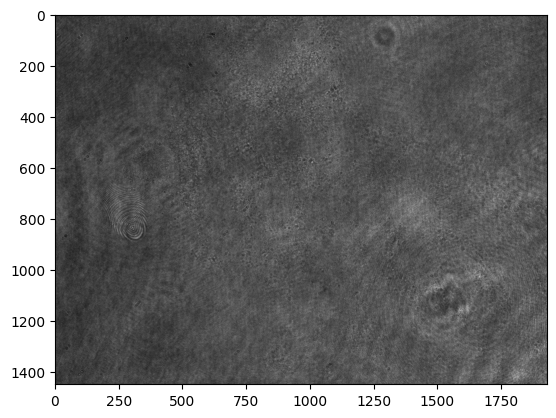

In [7]:
plt.imshow(data[0], cmap='gray')

In [8]:
filter_radius = 20
correct_fourier_peak = (0, 0)

frame = data[0]
frame = torch.tensor(frame)

yr, xr = frame.shape

X = torch.arange(frame.shape[0])
Y = torch.arange(frame.shape[1])
X, Y = torch.meshgrid(X, Y, indexing='ij')
position_matrix = torch.sqrt(X**2 + Y**2)

kx = torch.linspace(torch.pi, torch.pi, xr) 
ky = torch.linspace(torch.pi, torch.pi, yr)
KX, KY = torch.meshgrid(kx, ky, indexing='ij')

# Initialize FourierPeakFinder
finder = ru.FourierPeakFinder(position_matrix, filter_radius, correct_fourier_peak, KX, KY, X, Y)


# Find peak coordinates in Fourier space
kx_add_ky, dist_peak = finder.find_peak_coordinates(frame)

In [9]:
position_matrix.shape

torch.Size([1450, 1930])